# Planning and analysis of Thompson Sampling for PETase secretion

The purpose of this notebook is to apply the accompanying Python package _cutisplit_ to the screening of 24 combinations of signal peptides from _Bacillus subtilis_ with two different enzymes, leaf-branch-compost cutinase (LCC) and polyester hydrolase (PE-H).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import calibr8
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pyrff
try:
    import pymc as pymc3
except:
    import pymc3

import cutisplit
import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc 4.0.0b2
calibr8 6.5.2


## Specify the run to be analyzed
Results will be saved in a subfolder named after the run ID. The applied calibration model must be fitted in a seperate notebook.

Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 2 does not exist and loop will be exited
Error while reading the files. Repetition 2 does not exist and loop will be exited


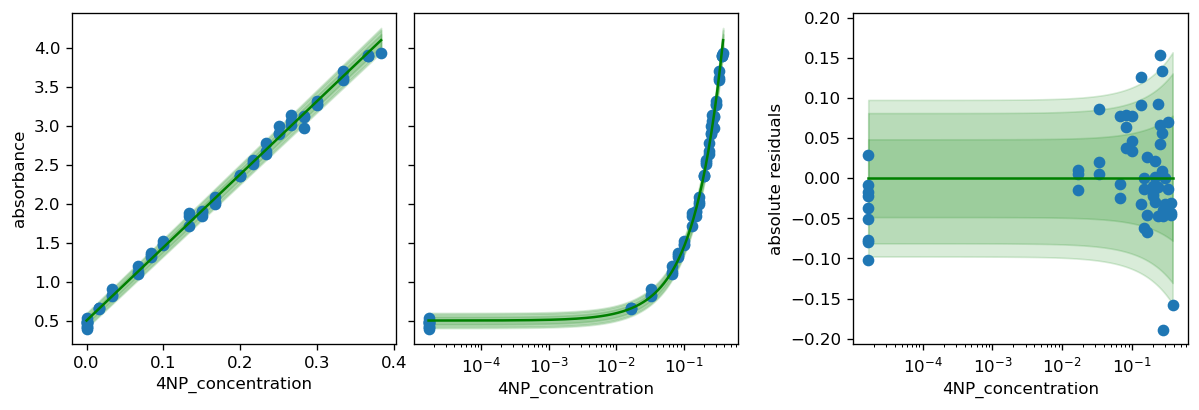

In [3]:
RUN_ID = "Fermentation"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol)


df_inputs, df_kinetics = run_analysis.read_rounds(["BWA7DQ", "BZACW9", "C3C1XZ", "Fermentation", "Fermentation_YoaW"])

## Creating the Model

In [4]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

c:\users\helleckes\repos\pymc\pymc\data.py:640: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


strain              (24,)	AbnA30, AmyE30, AprE30, …, YwmC30
culture_id          (92,)	BWA7DQ_A02, BWA7DQ_A04, BWA7DQ_A05, …, Fermentation_YoaW_D01
kinetic_id          (400,)	BWA7DQ_1_B01, BWA7DQ_1_B02, BWA7DQ_1_B03, …, Fermentation_YoaW_1_H12
column_id           (12,)	1, 2, 3, …, 12
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

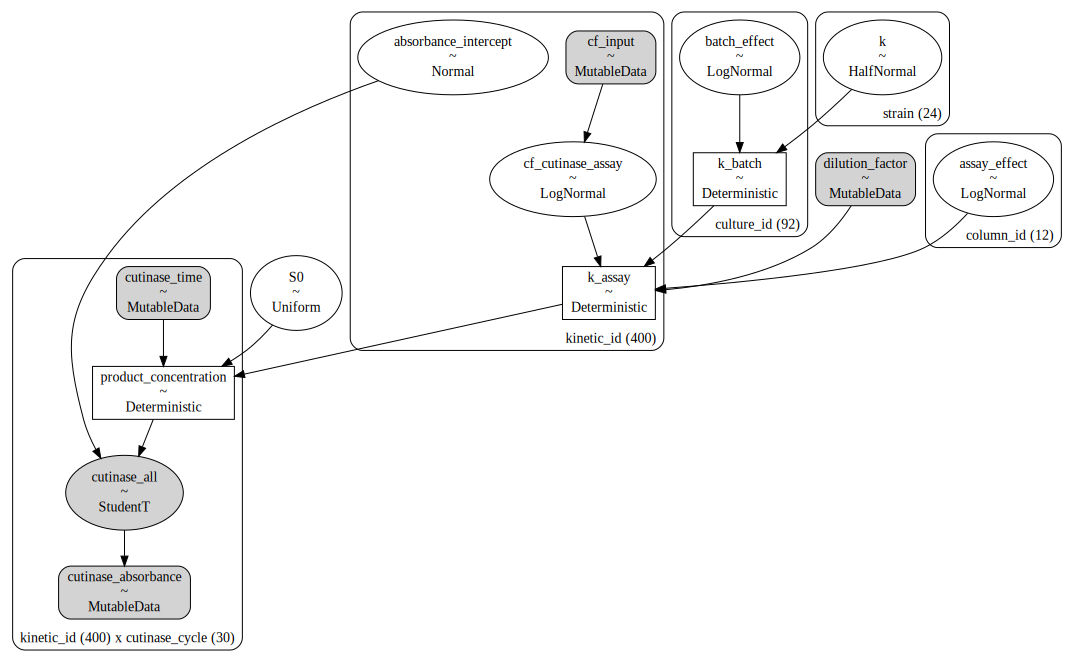

In [5]:
pymc3.model_to_graphviz(model.pmodel)

Run the next cell to sample the model parameters via MCMC. To only inspect the data, skip the next two code cells.

In [ ]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

The result should be saved such that the analysis can run in another notebook.

In [ ]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_mcmc.nc")

Execute the next cell in case you want to reload saved data

In [6]:
idata =  arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_BioLector+Fermentation(LipALipBYoaW).nc")

## Visualization
Visualize data for quality checks.

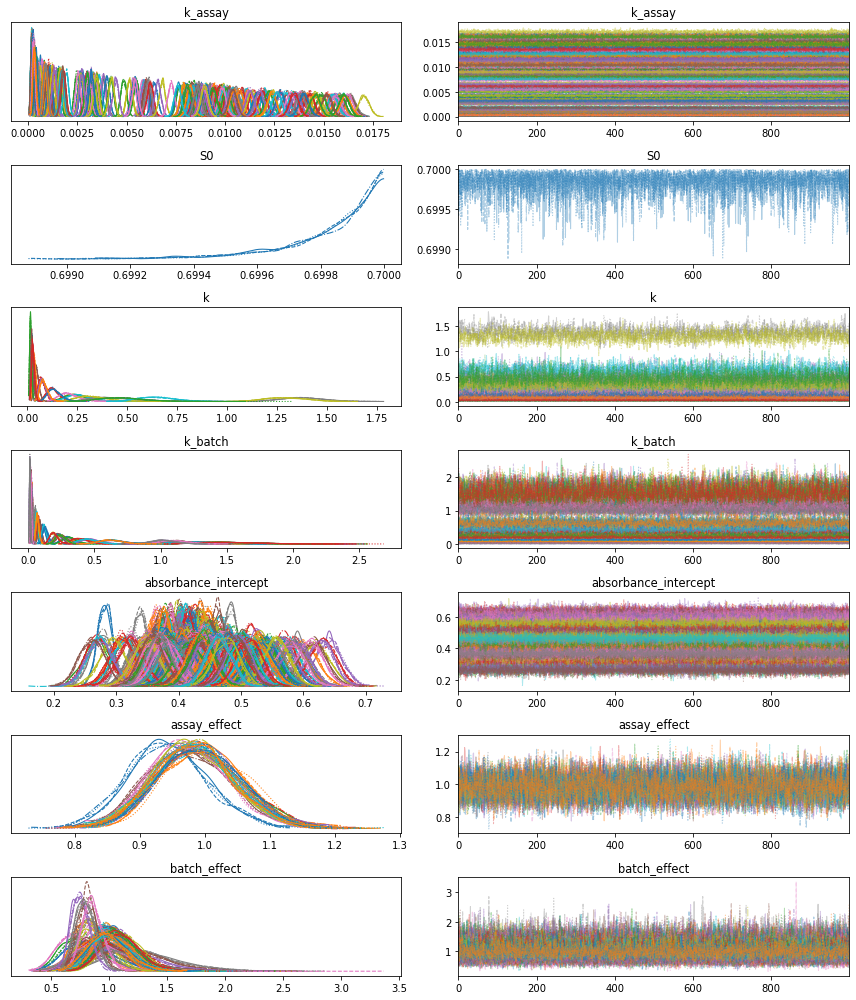

In [7]:
arviz.plot_trace(idata, var_names=[
    "k_assay", "S0", "k", "k_batch", "absorbance_intercept", "assay_effect", "batch_effect"
]);
pyplot.tight_layout()
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5_v2\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (144) is smaller than the number of resulting pair plots with these variables, generating only a 16x16 grid
  warnings.warn(


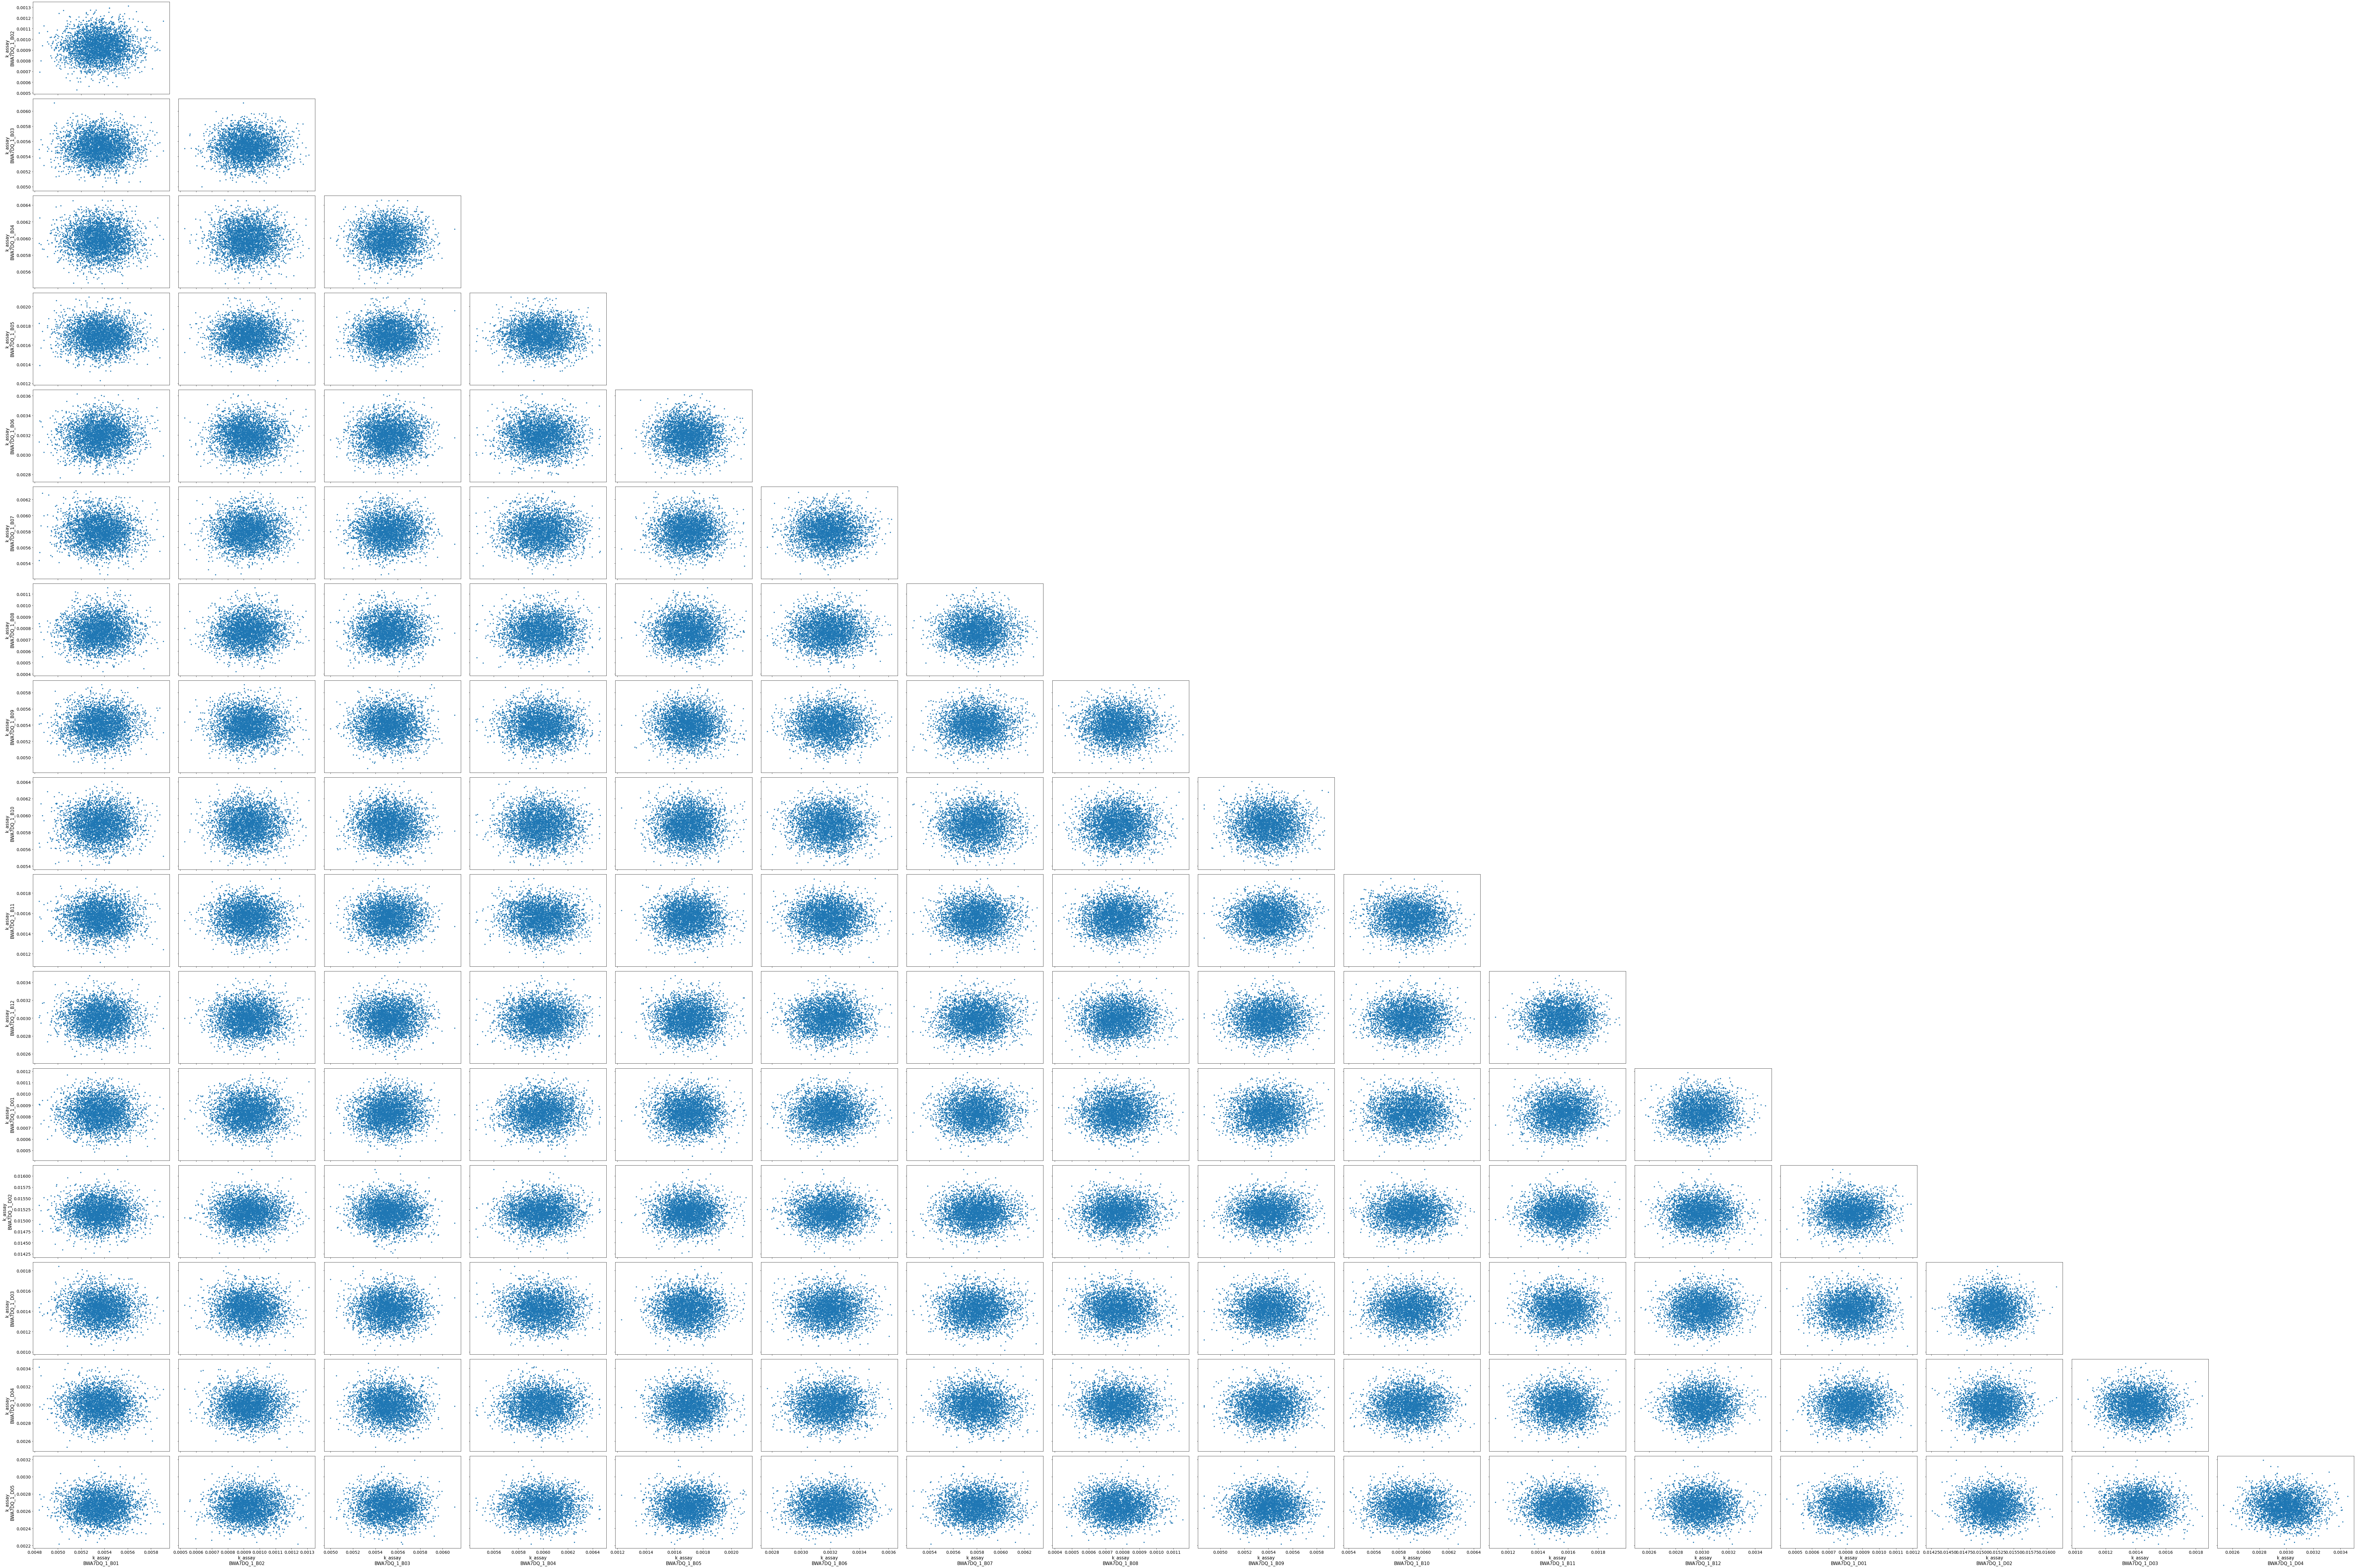

In [8]:
arviz.rcParams['plot.max_subplots'] = 144
arviz.plot_pair(idata, var_names=[
    "k_assay", 
    "k", "k_batch", "S0", 
    "absorbance_intercept"
]);
pyplot.tight_layout()

### Visualize different parameters for inspection.
ArViZ provides useful functions for quality assurance. Here, we show the assay effect in a so-called forest plot.

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

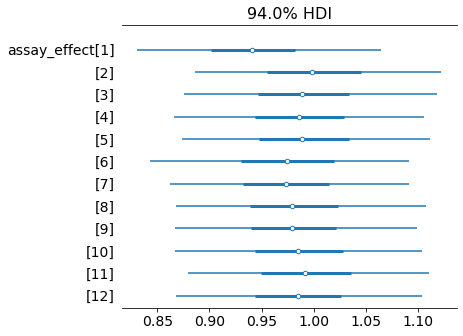

In [9]:
arviz.plot_forest(idata, var_names=["assay_effect"], combined=True)

## KPI and Thompson Sampling
Let's first visualize the posterior distributions for each signal peptide concerning the KPI, the kinetic rate constant $k$.

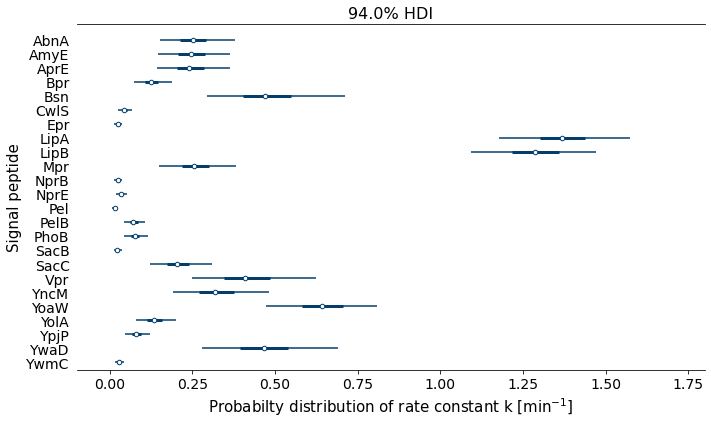

In [10]:
fig, ax = pyplot.subplots(figsize=(10,6))
arviz.plot_forest(idata, var_names=["k"], combined=True, ax=ax, colors=["#023D6B"])
pyplot.xlabel("Probabilty distribution of rate constant k [min$^{-1}$]", size=15)
strains = numpy.unique([
    strain[:-2]
    for strain in df_inputs.strain.values
])
ax.set_yticklabels(strains[::-1])
ax.set_ylabel("Signal peptide", size=15)
ax.set_xlim(-0.1, 1.8)
pyplot.tight_layout()
#pyplot.savefig(fr"{resultpath}\{RUN_ID}_kprobs.png", dpi=200)

### Thompson Sampling
Using these posterior distributions, we can now apply the Thompson Sampling to draw strains for the next round.
We use the [pyrff](https://github.com/michaelosthege/pyrff) Python package to take batch samples.

In [11]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
strains = numpy.unique(df_inputs.strain.values)
pyrff.sample_batch(
    posterior.k.values,
    ids=strains,
    batch_size=12,
    correlated=True
)

('LipA30',
 'LipA30',
 'LipA30',
 'LipA30',
 'LipB30',
 'LipA30',
 'LipA30',
 'LipB30',
 'LipB30',
 'LipA30',
 'LipA30',
 'LipA30')

Likewise, the package can be used to sample the probabilities for each variant to be the best.

In [12]:
probs = pyrff.sampling_probabilities(
    posterior.k.values,
    correlated=True
)

These can be visualized in a bar plot.

(0.0, 0.8)

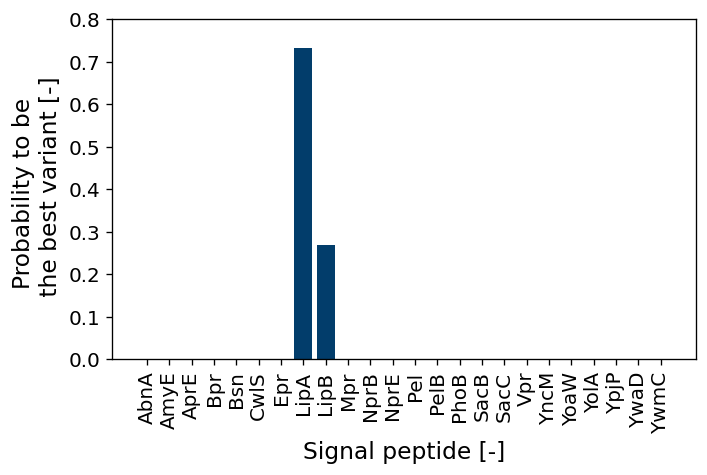

In [13]:
fig, ax = pyplot.subplots(figsize=(6,4), dpi=120)
ax.bar(x=numpy.arange(len(probs)), height=probs,color="#023D6B")
#ax.set_xlim(-0.2,23.2)
old_strains= [
    strain.split("3")[0]
    for strain in numpy.unique(df_inputs.strain.values)
]
ax.set_xticks(numpy.arange(len(probs)), labels=old_strains, rotation=90, size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Probability to be \n the best variant [-]", size=14)
ax.set_xlabel("Signal peptide [-]", size=14)
pyplot.tight_layout()
pyplot.ylim(0,0.8)
#pyplot.savefig(fr"{resultpath}\{RUN_ID}_tsprobs.png", dpi=200)